In [41]:
# import libraries
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import scipy.stats as stats

In [42]:
nPerClust = 300
blur = 1

A = [1,1]
B = [5, 1]
C = [4, 3]

a = [A[0]+np.random.randn(nPerClust)*blur, A[1]+np.random.randn(nPerClust)*blur]
b = [B[0]+np.random.randn(nPerClust)*blur, B[1]+np.random.randn(nPerClust)*blur]
c = [C[0]+np.random.randn(nPerClust)*blur, C[1]+np.random.randn(nPerClust)*blur]

labels_np = np.hstack((np.zeros((nPerClust)), np.ones((nPerClust)), 1+np.ones((nPerClust))))

data_np = np.vstack((np.array(a).T, np.array(b).T, np.array(c).T))

data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=.2)

datasetTrain = TensorDataset(X_train, y_train)
datasetTest = TensorDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(datasetTrain, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(datasetTest, batch_size=datasetTest.tensors[0].shape[0])

In [44]:
def creatAnn(optimAlgo):
    class ANN(nn.Module):
        def __init__(self):
            super().__init__()
            self.input = nn.Linear(2,8)

            self.fc1 = nn.Linear(8,8)

            self.output = nn.Linear(8,3)



        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
        
    net = ANN()
    lossfun = nn.CrossEntropyLoss()
    optifun = getattr(torch.optim, optimAlgo)
    optimizer = optifun(net.parameters(), lr=.01)
    
    return net, lossfun, optimizer


In [45]:
o = creatAnn("Adam")[2]
o

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [46]:

def trainModel(ann, lossfun, optimizer):
    trainAcc = []
    testAcc = []
    losses = []
    
    for epoch in range(50):
        batchAcc = []
        batchLoss = []
        ann.train()
        for X,y in train_loader:
            y_pred = ann(X)
            
            loss = lossfun(y_pred,y)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*(torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item()))
            batchLoss.append(loss.item())
            
            
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        ann.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            y_pred = ann(X)
            
        testAcc.append(100*(torch.mean((torch.argmax(y_pred, axis=1) == y).float()).item()))
        
    return trainAcc, testAcc, losses

In [47]:
optimns = ["SGD","Adam", "RMSprop"]
train = []
test = []
loss = []
for i in optimns:
    net, lossfun, optimizer = creatAnn(i)
    a = trainModel(net, lossfun, optimizer)
    train.append(a[0])
    test.append(a[1])
    loss.append(a[2])


In [48]:
train = np.array(train)
test = np.array(test)
loss = np.array(loss)

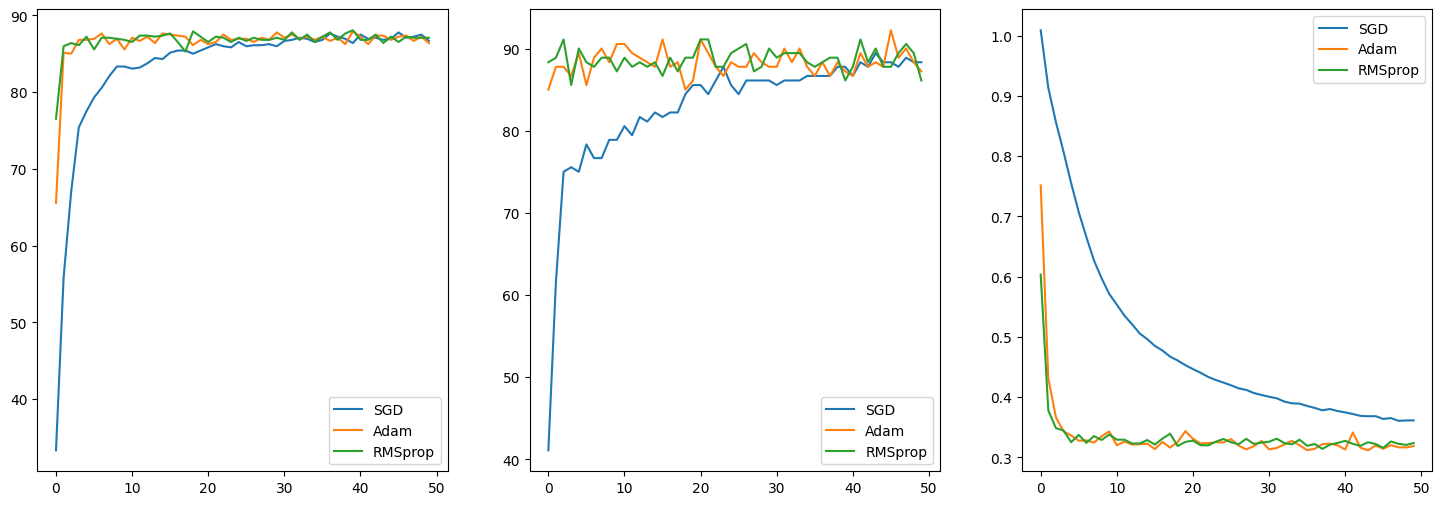

In [49]:
fig,ax = plt.subplots(1,3,figsize=(18,6))

ax[0].plot(train.T)
ax[0].legend(optimns)

ax[1].plot(test.T)
ax[1].legend(optimns)

ax[2].plot(loss.T)
ax[2].legend(optimns)



plt.show()